# Praktikum Informationstechnik im Maschinenbau II
## P09 - Daten einlesen, zusammenführen und analysieren mit Pandas

# Analyse von GPS Daten

In dieser Aufgabe importieren wir eine Exceltabelle mit GPS-Messdaten und analysieren den Messfehler. 

Die Arbeitsschritte:
1. Laden der Exceltabelle. Ein Arbeitblatt enthält die Rohdaten mit Zeitstempel, ein anderes Arbeitsblatt enthält die gemessenen Fehler in Länge und Breite jeweils in Meter
2. Prüfen der beiden Arbeitblätter auf Kompatibilität zueinander
3. Zusammenführen in ein gemeinsames `pandas.DataFrame`
4. Prüfen der Positionsfehler auf Mittelwert=0, ggf. Korrektur
5. Berechnen der Messabweichung (euklidischer Abstand zwischen gemessener und echter Position). Angabe eines Werts für die Messabweichung, die in 95% der Fälle nicht überschritten wird (95%-Quantil)
6. Darstellung der Messabweichung über der Zeit, Darstellung der GPS-Fehler als scatter-Plot

## Ergebnis: Scatter Plot

![result.png](result.png)

## Bonus (nicht Bestandteil der Aufgabe): GPS-Daten auf einer Höhenkarte

![hoehen.png](hoehen.png)


In [37]:
# Importieren
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Arbeitsschritt 1
- Laden Sie die beiden in der Excel-Datei `data/GPS_data.xls`. enthaltenden Arbeitsblätter in DataFrames `df_raw` und `df_analysis`. 
- Geben Sie die Strukturen und die Datentypen der DataFrames mit `.info()` aus.
- Überlegen Sie sich eine Strategie, wie Sie ein DataFrame erzeugen können, das alle Spalten enthält.
- Schauen Sie sich in den Daten um

In [2]:
# Laden von GPS_data.xls, Ausgeben der Arbeitsblattnamen
gps = pd.read_excel('GPS_data.xls', sheet_name=None)
gps

{'px4_raw':       Header_secs   Latitude  Longitude
 0      1602156874  50.761040   6.074403
 1      1602156875  50.761039   6.074403
 2      1602156877  50.761039   6.074402
 3      1602156878  50.761039   6.074401
 4      1602156879  50.761040   6.074400
 ...           ...        ...        ...
 3994   1602161301  50.761018   6.074467
 3995   1602161303  50.761018   6.074467
 3996   1602161304  50.761018   6.074467
 3997   1602161305  50.761018   6.074467
 3998   1602161306  50.761018   6.074467
 
 [3999 rows x 3 columns],
 'px4_analysis':        Latitude  Longitude       lat    dx (m)    dy (m)
 0     50.761040   6.074403  0.885947  3.350206 -0.457228
 1     50.761039   6.074403  0.885947  3.392383 -0.435002
 2     50.761039   6.074402  0.885947  3.441590 -0.435002
 3     50.761039   6.074401  0.885947  3.497827 -0.435002
 4     50.761040   6.074400  0.885947  3.554064 -0.446115
 ...         ...        ...       ...       ...       ...
 3994  50.761018   6.074467  0.885947 -1.120618

In [3]:
# Zuweisen des Dataframe df_raw, Ausgabe zusammenfassender Informationen
df_raw = gps['px4_raw']
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Header_secs  3999 non-null   int64  
 1   Latitude     3999 non-null   float64
 2   Longitude    3999 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 93.9 KB


In [4]:
# Zuweisen des Dataframe df_analysis, Ausgabe zusammenfassender Informationen
df_analysis = gps['px4_analysis']
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   3999 non-null   float64
 1   Longitude  3999 non-null   float64
 2   lat        3999 non-null   float64
 3   dx (m)     3999 non-null   float64
 4   dy (m)     3999 non-null   float64
dtypes: float64(5)
memory usage: 156.3 KB


In [5]:
# Umschauen in den Dataframes, Anfang und Ende
df_raw.sample(10)

,Header_secs,Latitude,Longitude
663,1602157610,50.761055,6.074396
1293,1602158306,50.761021,6.074445
3438,1602160686,50.761039,6.074455
3441,1602160689,50.761038,6.074454
787,1602157747,50.761074,6.074412
3324,1602160560,50.761036,6.074459
1302,1602158316,50.761019,6.074447
2159,1602159264,50.761038,6.074454
2687,1602159852,50.761037,6.074448
2463,1602159604,50.761049,6.074442


In [6]:
df_analysis.sample(10)

,Latitude,Longitude,lat,dx (m),dy (m)
558,50.761033,6.074403,0.885947,3.336147,0.298456
1142,50.761059,6.074446,0.885947,0.362627,-2.613150
1650,50.761040,6.074457,0.885947,-0.396569,-0.512793
1850,50.761033,6.074442,0.885947,0.636781,0.242891
2173,50.761037,6.074456,0.885947,-0.368451,-0.190516
1706,50.761030,6.074448,0.885947,0.165798,0.631846
3320,50.761037,6.074458,0.885947,-0.516072,-0.112725
3011,50.761031,6.074445,0.885947,0.390746,0.498490
3776,50.761017,6.074454,0.885947,-0.255977,2.043197
3283,50.761037,6.074460,0.885947,-0.670724,-0.201629


### Arbeitsschritt 2 

Vorbereitung zum Merge der beiden Tabellen entsprechend Ihrer Strategie

In [7]:
np.isclose(df_raw.Longitude,df_analysis.Longitude).all()

True

In [8]:
np.isclose(df_raw.Longitude,df_analysis.Latitude).all()

False

### Arbeitsschritt 3

Merging und Bereinigen

- Beide Dataframes nach Ihrer gewählten Strategie zusammenführen
- Die Spalte `Header_secs` mittels `pd.to_datetime()`in DateTime-Objekte überführen und diese mit `.set_index()` als neuen Index nutzen
- Aus dem resultieren DataFrame per `.drop()` überflüssige Spalten-Duplikate löschen
- Die Spalte `lat` löschen
- Namen der Spalten mit `.rename()` so bereinigen, dass man die Objekt-Schreibweise (`dataframe.spalte` statt `dataframe['spalte']`) nutzen kann

In [9]:
# Zusammenführen mit merge anhand der Indizes
df_gps = df_raw.merge(df_analysis, left_index=True, right_index=True)
df_gps

,Header_secs,Latitude_x,Longitude_x,Latitude_y,Longitude_y,lat,dx (m),dy (m)
0,1602156874,50.761040,6.074403,50.761040,6.074403,0.885947,3.350206,-0.457228
1,1602156875,50.761039,6.074403,50.761039,6.074403,0.885947,3.392383,-0.435002
2,1602156877,50.761039,6.074402,50.761039,6.074402,0.885947,3.441590,-0.435002
3,1602156878,50.761039,6.074401,50.761039,6.074401,0.885947,3.497827,-0.435002
4,1602156879,50.761040,6.074400,50.761040,6.074400,0.885947,3.554064,-0.446115
...,...,...,...,...,...,...,...,...
3994,1602161301,50.761018,6.074467,50.761018,6.074467,0.885947,-1.120618,1.976519
3995,1602161303,50.761018,6.074467,50.761018,6.074467,0.885947,-1.134677,1.987632
3996,1602161304,50.761018,6.074467,50.761018,6.074467,0.885947,-1.127648,1.987632
3997,1602161305,50.761018,6.074467,50.761018,6.074467,0.885947,-1.148736,1.998745


In [10]:
df_gps.Header_secs = pd.to_datetime(df_gps.Header_secs, unit='s')
df_gps = df_gps.set_index("Header_secs")
df_gps.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3999 entries, 2020-10-08 11:34:34 to 2020-10-08 12:48:26
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Latitude_x   3999 non-null   float64
 1   Longitude_x  3999 non-null   float64
 2   Latitude_y   3999 non-null   float64
 3   Longitude_y  3999 non-null   float64
 4   lat          3999 non-null   float64
 5   dx (m)       3999 non-null   float64
 6   dy (m)       3999 non-null   float64
dtypes: float64(7)
memory usage: 249.9 KB


In [11]:
df_gps = df_gps.drop(['Latitude_y', 'Longitude_y', 'lat'], axis=1)
df_gps = df_gps.rename({'Latitude_x':'Latitude', 'Longitude_x': 'Longitude', 'dx (m)': 'dx', 'dy (m)': 'dy'}, axis=1)
df_gps

,Latitude,Longitude,dx,dy
Header_secs,,,,
2020-10-08 11:34:34,50.761040,6.074403,3.350206,-0.457228
2020-10-08 11:34:35,50.761039,6.074403,3.392383,-0.435002
2020-10-08 11:34:37,50.761039,6.074402,3.441590,-0.435002
2020-10-08 11:34:38,50.761039,6.074401,3.497827,-0.435002
2020-10-08 11:34:39,50.761040,6.074400,3.554064,-0.446115
...,...,...,...,...
2020-10-08 12:48:21,50.761018,6.074467,-1.120618,1.976519
2020-10-08 12:48:23,50.761018,6.074467,-1.134677,1.987632
2020-10-08 12:48:24,50.761018,6.074467,-1.127648,1.987632


### Arbeitsschritt 4

- Prüfen der Mittelwerte von `dx`und `dy`
- Verschieben von `dx` und `dy` um ihren Mittelwert

In [14]:
# Mittelwerte beider Spalten anzeigen
df_gps[['dx','dy']].mean()

dx    0.626589
dy   -0.368382
dtype: float64

Offenbar sind die Mittelwerte stark von Null verschieden. `dx` und `dy` durch Abziehen der Mittelwerte bereinigen 

>Theoretisch müsste man auch die Positionen korrigieren. Das wäre aber wegen Grad und Meter kompliziert

In [20]:
# dx und dy  um Mittelwerte verschieben
df_gps.dx = df_gps.dx - df_gps.dx.mean()
df_gps.dy = df_gps.dy - df_gps.dy.mean()

df_gps.describe()

,Latitude,Longitude,dx,dy
count,3999.000000,3999.000000,3.999000e+03,3.999000e+03
mean,50.761039,6.074442,-5.685763e-17,5.685763e-17
std,0.000012,0.000019,1.335040e+00,1.351701e+00
min,50.761008,6.074382,-2.815706e+00,-3.978396e+00
25%,50.761031,6.074435,-8.895964e-01,-9.389901e-01
50%,50.761038,6.074445,-2.428735e-01,7.784936e-02
75%,50.761047,6.074455,5.128081e-01,8.779854e-01
max,50.761075,6.074482,4.234980e+00,3.411749e+00


### Arbeitsschritt 5: 

- Neue Spalte einfügen mit euklidischem Abstand
- Ausgeben
- Statistische Auswertung mit `describe(percentiles=...)` und/oder `.quantile()`

In [22]:
# Spalte abs_error nach Pythagoras berechnen und ins DataFrame aufnehmen
df_gps['abs_error'] = np.sqrt(df_gps.dx**2 + df_gps.dy**2) 
df_gps

,Latitude,Longitude,dx,dy,abs_error
Header_secs,,,,,
2020-10-08 11:34:34,50.761040,6.074403,2.723616,-0.088846,2.725065
2020-10-08 11:34:35,50.761039,6.074403,2.765794,-0.066620,2.766596
2020-10-08 11:34:37,50.761039,6.074402,2.815001,-0.066620,2.815789
2020-10-08 11:34:38,50.761039,6.074401,2.871238,-0.066620,2.872010
2020-10-08 11:34:39,50.761040,6.074400,2.927474,-0.077733,2.928506
...,...,...,...,...,...
2020-10-08 12:48:21,50.761018,6.074467,-1.747207,2.344901,2.924260
2020-10-08 12:48:23,50.761018,6.074467,-1.761267,2.356014,2.941575
2020-10-08 12:48:24,50.761018,6.074467,-1.754237,2.356014,2.937371


In [30]:
# Statistik der Absoluten Fehler
df_gps.abs_error.describe(percentiles=[0.95])

count    3999.000000
mean        1.648279
std         0.944418
min         0.032935
50%         1.498095
95%         3.366621
max         4.614016
Name: abs_error, dtype: float64

In [29]:
df_gps.abs_error.quantile(0.95)

3.3666212638833257

### Arbeitsschritt 6

Ausgabe Absoluter Fehler über der Zeit


<AxesSubplot: xlabel='Header_secs'>

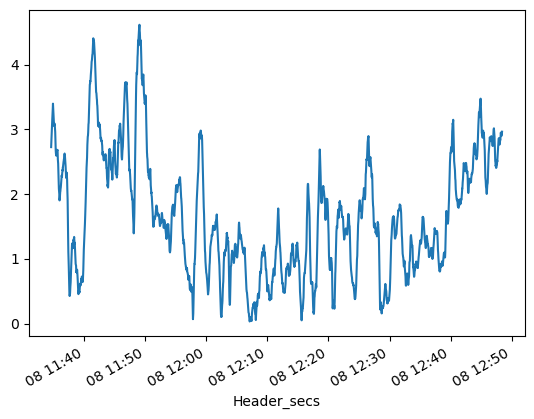

In [35]:
# Plot
df_gps.abs_error.plot()

### Scatter Plot

- Der Scatter Plot ist eine Punktewolke aus den dx/dy Wertepaaren
- Versuchen Sie, eine Darstellung wie oben zu erzeugen
    Tipps:
    - mit `sample()` auf eine handliche Anzahl (z.B. 100) reduzieren
    - Koordinatensystem in die Mitte (`spines`)
    - Gleiche Achsenteilungen für x und y (Stichwort `aspect`)
    - Einzeichnen eines Kreises

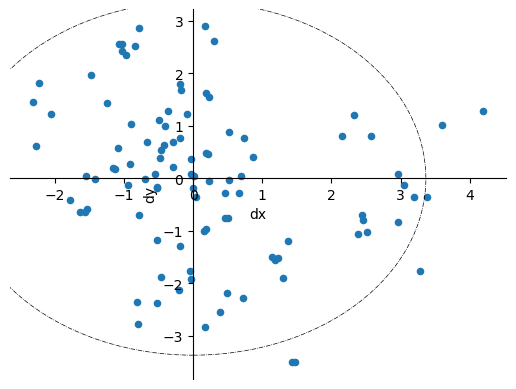

In [48]:
fig, ax = plt.subplots()
df_gps.sample(100).plot.scatter('dx','dy', ax = ax)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.add_patch(plt.Circle((0,0), df_gps.abs_error.quantile(0.95), fill=False, linestyle='-.', linewidth=0.5))
